# Fábrica de Chocolates

O processo é definido por uma entrada de quantidade de chocolate (controlada), VAR_1 e VAR_2 (não controladas) e uma saída que corresponde ao peso do bombom gerado.\
A preocupação do cliente é a qualidade do processo, já que ele possui uma grande dificuldade de modelá-lo.\
Essa dificuldade vem do fato de apenas uma variável poder ser controlada e o cliente não consegue enxergar um padrão no impacto das variáveis não controláveis no peso do bombom.\
Também foi fornecida uma métrica de custo, que ajuda a entender a eficiência do processo.

Sendo assim, temos:
* Variável alvo: peso do bombom
* Variáveis do processo: quantidade de chocolate, Var 1 e Var 2
* Variável controlada: quantidade de chocolate

* Peso ideal do bombom - 10g
    * Se pesar menos de 9g é descartado e não tem limite superior 

Métrica de custo
  - deve ser minimizado
  - p = peso do bombom
  
$$ C(p) = \dfrac{200}{1+e^{10.(p-9.5)}}+\dfrac{200}{1+e^{-0.8.(p-12)}} $$

In [1]:
# importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import shap
from scipy.optimize import fmin


c:\Users\012981631\Anaconda3\envs\estudos\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# importanto arquivo para análises e treino

df = pd.read_excel('../registros-prod.xlsx')

## Análise Descritiva

### Sobre o dataset

In [3]:
# 5 primeiras linhas do dataset
df.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
0,320.15,0.88,A,10.144919
1,320.14,1.55,A,11.547027
2,284.85,2.97,A,11.112109
3,263.92,2.36,C,9.900123
4,276.22,2.98,C,10.079822


In [4]:
# linhas e colunas
df.shape

(500, 4)

In [5]:
# informação de colunas, dados não nulos e tipo de variável
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   QTD_CHOC     500 non-null    float64
 1   VAR_1        500 non-null    float64
 2   VAR_2        500 non-null    object 
 3   PESO_BOMBOM  500 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.8+ KB


In [6]:
# informações estatísticas das variáveis contínuas, como média, mediana, quartis, etc

df.describe()

,QTD_CHOC,VAR_1,PESO_BOMBOM
count,500.000000,500.000000,500.000000
mean,291.264600,2.098180,10.395002
std,45.182499,0.711166,1.572233
min,112.910000,0.050000,4.543124
25%,259.267500,1.630000,9.425819
50%,295.450000,2.300000,10.334273
75%,325.137500,2.672500,11.379932
max,436.070000,2.980000,17.362728


In [7]:
# districuição das classes (e quais são) das variáveis categóricas
df.VAR_2.value_counts()

C    177
B    165
A    158
Name: VAR_2, dtype: int64

In [8]:
# distribuição das classes em porcentagens

df.VAR_2.value_counts(normalize = True)

C    0.354
B    0.330
A    0.316
Name: VAR_2, dtype: float64

In [9]:
# confirmando a não existência de nulos

df.isna().sum()

QTD_CHOC       0
VAR_1          0
VAR_2          0
PESO_BOMBOM    0
dtype: int64

In [10]:
# verificação de dados duplicados

df.duplicated().sum()

0

Dataset sem variáveis nulas e sem duplicatas\
4 colunas e 500 linhas\
Numéricas: QTD_CHOC, PESO_BOMBOM e VAR_1\
Categórica: VAR_2 - 3 classes (A, B e C)\
Target contínuo (PESO_BOMBOM)

### Distribuição das variáveis

In [11]:
# separação do dataset em bombons úteis (peso >= 9g) e bombons descartados (peso < 9g) para comparação da distribuição das variáveis

# bombons úteis

bombom = df[df.PESO_BOMBOM >= 9].copy()

# bombons descartados
descarte = df[df.PESO_BOMBOM < 9].copy()

# % de bombom descartado
porc = descarte.shape[0] / df.shape[0] *100

print(r'% de bombom descartado (peso < 9g): {}%'.format(porc))

% de bombom descartado (peso < 9g): 16.6%


In [12]:
# função criada para facilitar as análises de comparação dos bombons totais, úteis e descartados de cada variável

def plot_dist(var, totais, uteis, descartados):
    """Plota histograma, violin plot e boxplot da coluna selecionada para 

    Args:
        var (str): coluna do dataframe
    """
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle('Distribuição {}'.format(var))

    # totais

    sns.histplot(ax=axes[0, 0], x = totais[var], kde = True)
    axes[0, 0].set_title('Bombons totais')

    sns.violinplot(ax=axes[1, 0], x=totais[var])

    sns.boxplot(ax = axes[2, 0], x=totais[var], orient='h')

    # úteis

    sns.histplot(ax=axes[0, 1], x = uteis[var], color='g', kde = True)
    axes[0, 1].set_title('Bombons úteis')

    sns.violinplot(ax=axes[1, 1], x=uteis[var], palette=['g'])

    sns.boxplot(ax = axes[2, 1], x=uteis[var], orient='h', palette=['g'])

    # descartados

    sns.histplot(ax=axes[0, 2], x = descartados[var], color='r', kde = True)
    axes[0, 2].set_title('Bombons descartados')

    sns.violinplot(ax=axes[1, 2], x=descartados[var], palette=['r'])

    sns.boxplot(ax = axes[2, 2], x=descartados[var], orient='h', palette=['r'])

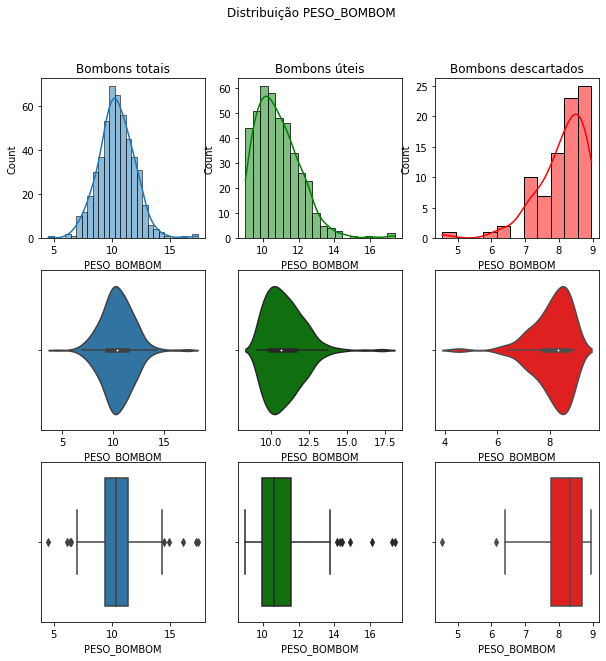

In [13]:
# distribuições PESO_BOMBOM

plot_dist('PESO_BOMBOM', df, bombom, descarte)

**PESO_BOMBOM**\
Como esperado, os pesos dos bombons têm maior recorrência próximo ao peso ideal (10g).\
Nos bombons totais a distribuição é normal, simétrica, média 10, que é o ideal para o fabricante.\
Para bombons úteis e descartados, a distribuição é assimétrica positiva e negativa, respectivamente - o que indica a moda próxima ao peso ideal do bombom (10g).

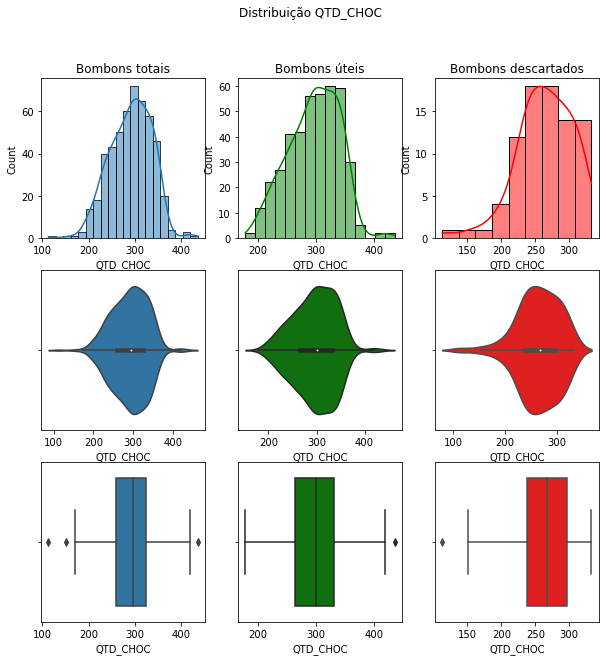

In [14]:
# distribuições QTD_CHOC

plot_dist('QTD_CHOC', df, bombom, descarte)

**QTD_CHOC**\
A distribuição da quantidade de chocolate é quase simétrica e apresenta uma mediana e moda muito próxima para os bombons totais e para os úteis.\
Os bombons descartados geralmente apresentam uma quantidade de chocolate menor, o que é esperado devido ao seu peso menor.

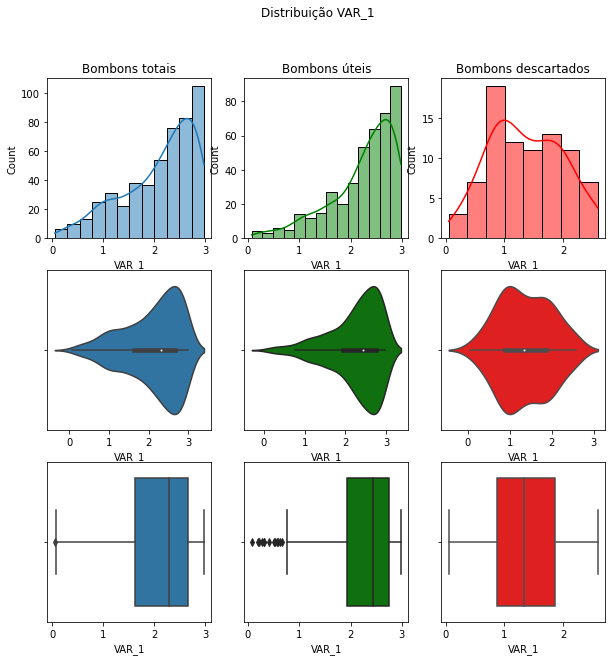

In [15]:
# distribuições VAR_1

plot_dist('VAR_1', df, bombom, descarte)

**VAR_1**\
A distribuição da variável 1 (para totais e úteis) muda completamente quando comparada à dos bombons descartados.\
Para os bombons totais e os úteis (que representam a maior parte do dataset), existe uma assimetria negativa e a VAR_1 se concentra entre +- 2 e 3, enquanto para bombons descartados, ela se concentra entre 1 e 2.

Text(0.5, 1.0, 'Bombons descartados')

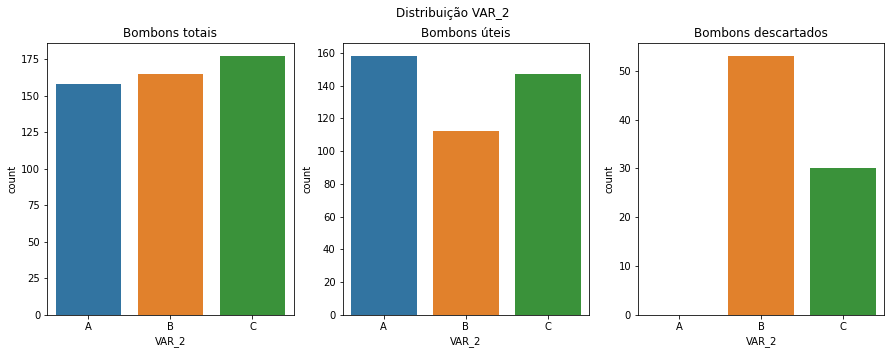

In [16]:
# distribuição da variável categórica VAR_2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribuição VAR_2')

sns.countplot(ax = axes[0], x = df.VAR_2, order=['A', 'B', 'C'])
axes[0].set_title('Bombons totais')

sns.countplot(ax = axes[1], x = bombom.VAR_2, order=['A', 'B', 'C'])
axes[1].set_title('Bombons úteis')

sns.countplot(ax = axes[2], x = descarte.VAR_2, order=['A', 'B', 'C'])
axes[2].set_title('Bombons descartados')

In [17]:
# porcentagem das distribuições em cada classe da variável categórica

print('% Bombons totais\n', df.VAR_2.value_counts(normalize=True))
print('% Bombons úteis\n', bombom.VAR_2.value_counts(normalize=True))
print('% Bombons descartados\n', descarte.VAR_2.value_counts(normalize=True))

% Bombons totais
 C    0.354
B    0.330
A    0.316
Name: VAR_2, dtype: float64
% Bombons úteis
 A    0.378897
C    0.352518
B    0.268585
Name: VAR_2, dtype: float64
% Bombons descartados
 B    0.638554
C    0.361446
Name: VAR_2, dtype: float64


**VAR_2**\
A distribuição de VAR_2 para os bombons totais é bem semelhante entre suas classes, todas na faixa dos 30%.\
Não existe nenhum caso de descarte para um bombom que tenha como VAR_2 = A.\
Entende-se que VAR_2 = B reduz o peso do bombom, visto que a maior parte dos bombons descartados assume essa categoria para VAR_2.

## Análise Diagnóstica

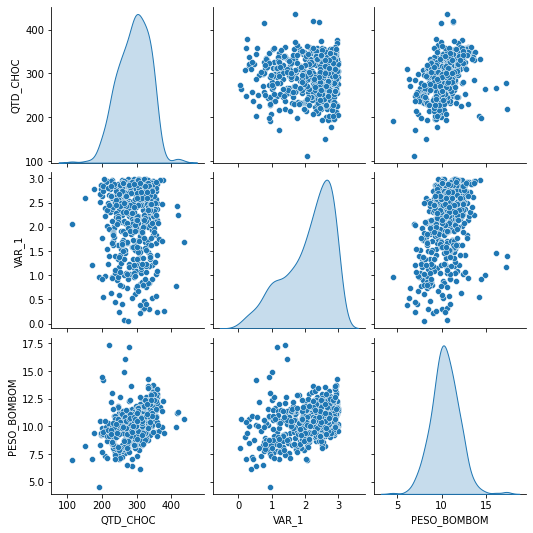

In [18]:
# distribuição das variáveis e relação das combinações, considerando o dataset inteiro

sns.pairplot(df, diag_kind='kde')

As distribuições já foram analisadas anteriormente.\
**PESO_BOMBOM x QTD_CHOC**
- Percebe-se uma leve relação direta entre os dois - um aumenta o outro.

**PESO_BOMBOM x VAR_1**
- Também existe uma pequena relação direta entre os dois.

**VAR_1 x QTD_CHOC**
- Não se percebe uma relação direta, a distibuição se assemelha a um retângulo.

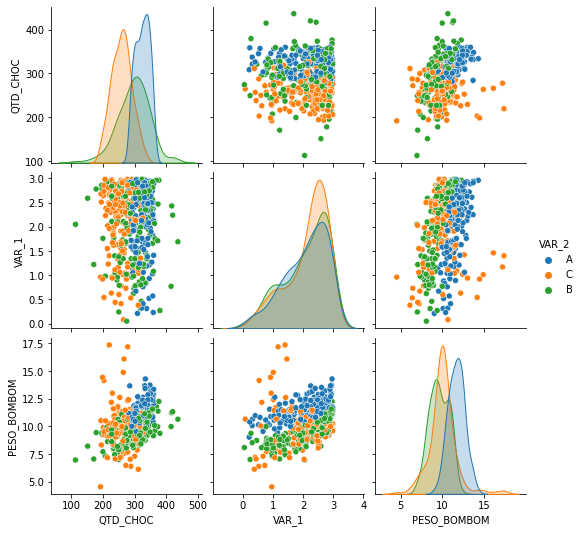

In [19]:
# distribuição - segmentada por VAR_2 - das variáveis e relação das combinações, considerando o dataset inteiro

sns.pairplot(df, diag_kind='kde', hue = 'VAR_2')

VAR_2 = A apresenta maior recorrência em maiores quantidades de chocolate e pesos maiores - o que faz sentido, já que em todas as suas "aparições" os bombons foram úteis.\
VAR_2 = B em geral possui uma distribuição de peso mais concentrada abaixo do peso ideal.\
Para VAR_1, as 3 classes de VAR_2 não apresentam diferenças significativas.

**PESO_BOMBOM x QTD_CHOC x VAR_2**
- VAR_2 = A apresenta peso e quantidade de chocolate mais altas.
- VAR_2 = B apresenta uma relaçao direta entre os dois.
- VAR_2 = C não apresenta muita relação entre as duas variáveis.

**PESO_BOMBOM x VAR_1 X VAR_2**
- Para as 3 classes de VAR_1 existe uma pequena relação direta, mas nada que chame muita atenção.

**VAR_1 x QTD_CHOC x VAR_2**
- Não se observa uma grande diferenciação para as 3 classes de VAR_2 nessas duas variáveis.

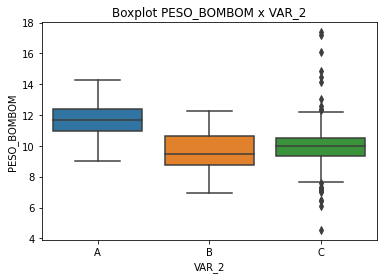

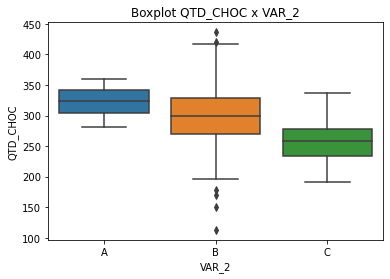

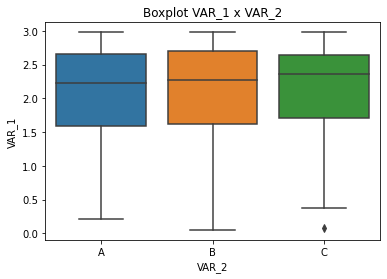

In [20]:
# boxplot das variáveis continuas segmentado para VAR_2

for var in ['PESO_BOMBOM', 'QTD_CHOC', 'VAR_1']:
    ax = sns.boxplot(x='VAR_2', y=var, data=df, order=['A', 'B', 'C'])
    ax.set_title(f'Boxplot {var} x VAR_2')
    plt.show()

As observações desses gráficos são semelhantes às das distribuições já apresentadas anteriormente.

Text(0.5, 1.0, 'Correlação variáveis contínuas')

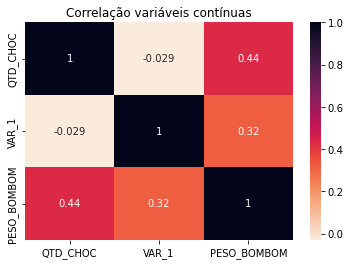

In [21]:
# correlação das variáveis contínuas

corrmatrix = df.corr()
f, ax = plt.subplots()
sns.heatmap(corrmatrix, cmap='rocket_r', annot=True, ax=ax)
plt.title('Correlação variáveis contínuas')

Text(0.5, 1.0, 'Mutual Info - Dependência')

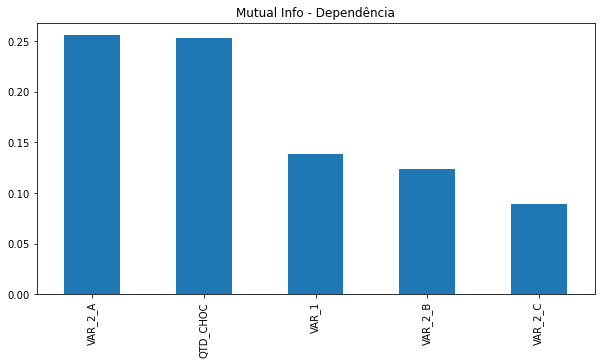

In [22]:
# mutual info para também analisar categóricas

# one hot encoding para separar as classes de VAR_2 em colunas
encoder = OneHotEncoder()
df_onehot = pd.DataFrame(encoder.fit_transform(df[['VAR_2']]).toarray())
df_onehot.columns = encoder.get_feature_names(['VAR_2'])
final_df = df.drop(columns = 'VAR_2').join(df_onehot)

# dependência do target perante à variável
mic = mutual_info_regression(final_df.drop(columns = ['PESO_BOMBOM']), final_df['PESO_BOMBOM'], n_neighbors=5, random_state=42)
plt.figure(figsize=(10, 5))
pd.Series(mic, index=final_df.drop(columns = 'PESO_BOMBOM').columns).sort_values(ascending=False).plot.bar()
plt.title('Mutual Info - Dependência')

Hipóteses
* QTD_CHOC: quanto maior a quantidade de chocolate, menor será o descarte de bombons.
* VAR_1: quanto maior essa variável, maior o peso do bombom - relação pouco forte.
* VAR_2:
    -  A: relação forte com maior peso do bombom (devido ao fato de não existir bombons descartados que apresentem essa classificação no dataset)
    -  B: relação fraca com maior peso do bombom (bombons descartados apresentam mais essa classificação)
    -  C: se encontra no meio termo entre as classes A e B, tendo alguns poucos casos de bombons inconformes

### Custo

In [23]:
# função criada para cálculo do custo de produção do bombom

def cost_value(peso):
    """Métrica de custo fornecida pelo fabricante.

    Args:
        peso (float): Peso do bombom

    Returns:
        float: Custo calculado
    """
    cost = (200/(1+math.e**(10*(peso-9.5)))) + (200/(1+math.e**(-0.8*(peso-12))))
    return cost

In [24]:
# criando coluna custo para análise

df_cost = df.copy()
df_cost['CUSTO'] = cost_value(df_cost['PESO_BOMBOM'])
df_cost.head()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
0,320.15,0.88,A,10.144919,37.278717
1,320.14,1.55,A,11.547027,82.076805
2,284.85,2.97,A,11.112109,65.905963
3,263.92,2.36,C,9.900123,35.014600
4,276.22,2.98,C,10.079822,36.024115


In [25]:
# informações estatísticas do custo (além das outras variáveis contínuas do dataset)

df_cost.describe()

,QTD_CHOC,VAR_1,PESO_BOMBOM,CUSTO
count,500.000000,500.000000,500.000000,500.000000
mean,291.264600,2.098180,10.395002,107.161983
std,45.182499,0.711166,1.572233,65.647587
min,112.910000,0.050000,4.543124,34.690631
25%,259.267500,1.630000,9.425819,49.183556
50%,295.450000,2.300000,10.334273,82.358225
75%,325.137500,2.672500,11.379932,173.128378
max,436.070000,2.980000,17.362728,215.271798


In [26]:
# custo mínimo presente no dataset

df_cost[df_cost['CUSTO'] == df_cost['CUSTO'].min()]

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM,CUSTO
417,261.12,2.31,C,9.948389,34.690631


Interessante observar que o peso mínimo não corresponde à quantidade de chocolate e nem peso do bombom mínimos.

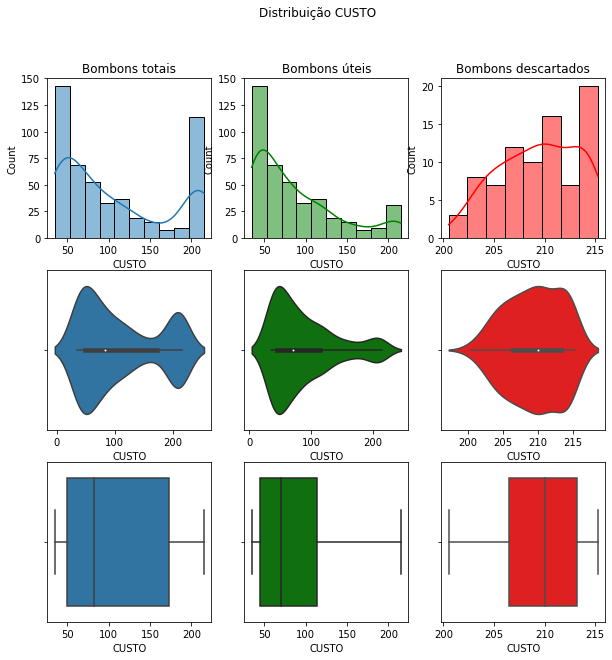

In [27]:
# separação do custo entre bombons totais, úteis e descartados e plot das distribuições

# bombons úteis

bombom_custo = df_cost[df_cost.PESO_BOMBOM >= 9].copy()

# bombom descartado

descarte_custo = df_cost[df_cost.PESO_BOMBOM < 9].copy()

# plot
plot_dist('CUSTO', df_cost, bombom_custo, descarte_custo)

Para os bombons totais, existem mais recorrência de custos mais baixos e altos (apesar de menor). Possuem uma baixa rcorrência de custos "médios".\
Comparando bombons úteis e descartados, observa-se que os úteis possuem um custo muito menor que os descartados.

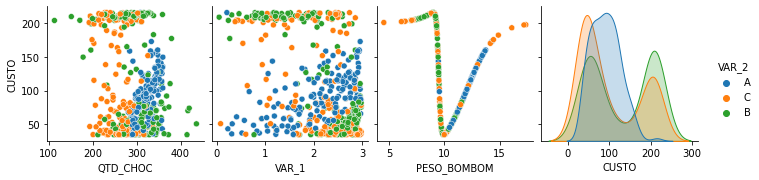

In [28]:
# distribuição segmentada em VAR_2 do custo em relação às outras variáveis

sns.pairplot(df_cost, y_vars=['CUSTO'], diag_kind='kde', hue = 'VAR_2')

Em geral, VAR_2 = A apresenta custos mais baixos quando comparada às outras classes e possui uma relação quase que proporcional à VAR_1.\
Para VAR_2 = B existe uma relação quase que inversa entre custo x qtd_choc e custo x var_1.\
VAR_2 = C não mostra um comportamento tão significativo quanto as outras.

Text(0.5, 1.0, 'Correlação variáveis contínuas')

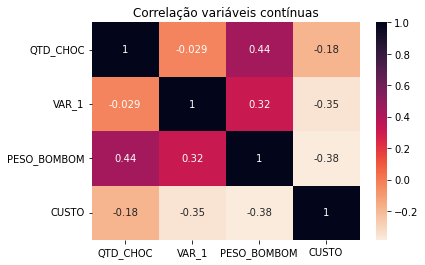

In [29]:
# correlação
corrmatrix_cost = df_cost.corr()
f, ax = plt.subplots()
sns.heatmap(corrmatrix_cost, cmap='rocket_r', annot=True, ax=ax)
plt.title('Correlação variáveis contínuas')

Text(0.5, 1.0, 'Mutual Info - Dependência')

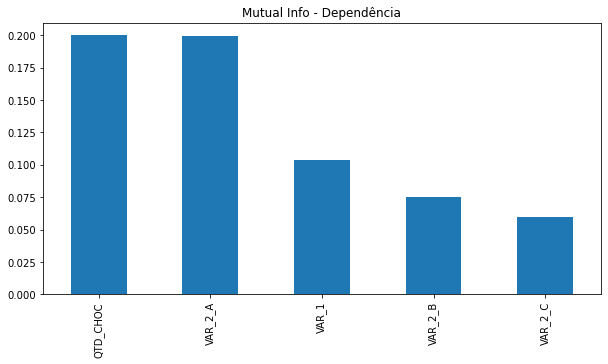

In [30]:
# mutual info para também analisar categóricas
encoder = OneHotEncoder()
df_onehot_cost = pd.DataFrame(encoder.fit_transform(df_cost[['VAR_2']]).toarray())
df_onehot_cost.columns = encoder.get_feature_names(['VAR_2'])
final_df_cost = df_cost.drop(columns = 'VAR_2').join(df_onehot_cost)

# dependência do target perante à variável
mic = mutual_info_regression(final_df_cost.drop(columns = ['CUSTO', 'PESO_BOMBOM']), final_df_cost['CUSTO'], n_neighbors=5, random_state=42)
plt.figure(figsize=(10, 5))
pd.Series(mic, index=final_df_cost.drop(columns = ['CUSTO', 'PESO_BOMBOM']).columns).sort_values(ascending=False).plot.bar()
plt.title('Mutual Info - Dependência')

Menor custo = 34.690631 para um peso de 9.948389.\
O custo dos bombons descartados é maior que o dos bombons úteis.\
VAR_2 = A apresenta, em média, um menor custo - o que faz sentido, pois elas sempre geram um bombom útil, que como visto, possuem um menor custo.\
Para maiores valores de VAR_1, menor será o custo.

## Análise Preditiva

In [31]:
# verificando existencia de variáveis constantes

quasi_constant = []
threshold=0.95
for col in final_df.columns:
    predominant = final_df[col].value_counts(normalize=True).iloc[0]
    if predominant >= threshold:
        quasi_constant.append(col)

quasi_constant

[]

Não existem variáveis constantes dentro de uma threshold de 95%

In [32]:
# verificando o pvalue usando OLS

for col in final_df.columns:
    X = final_df[col].copy()
    y = final_df['PESO_BOMBOM'].copy()
    X = sm.add_constant(X)
    result = sm.OLS(y, X, missing='drop').fit()
    print(col, result.pvalues[1])

QTD_CHOC 9.26313074899007e-25
VAR_1 4.1567963200082175e-13
PESO_BOMBOM 0.0
VAR_2_A 2.279386683669965e-40
VAR_2_B 1.7419834931671452e-16
VAR_2_C 4.832140918441264e-05


Todas as variáveis foram aceitas para um p-value < 0.05, então todas variáveis são significativas.

In [33]:
# deletando variáveis criadas
del ax, axes, bombom, bombom_custo, col, corrmatrix, corrmatrix_cost, descarte, descarte_custo, df_cost, df_onehot, df_onehot_cost, encoder, f, fig, final_df, final_df_cost, mic, porc, predominant, quasi_constant, result, threshold, var

In [34]:
# separando preditoras de variável alvo

X = df.drop(columns = 'PESO_BOMBOM').copy()
y = df['PESO_BOMBOM'].copy()

In [35]:
# separando treino e teste randomicamente - 30% para teste e 70% para treino

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# tratando variável categórica apenas para dados de treino (evitando data leak) - OneHotEncoding

encoder = OneHotEncoder()
X_onehot = pd.DataFrame(encoder.fit_transform(X_train[['VAR_2']].reset_index(drop=True)).toarray())
X_onehot.columns = encoder.get_feature_names(['VAR_2'])
train_X = X_train.reset_index(drop=True).drop(columns = 'VAR_2').join(X_onehot)

In [37]:
# encoder no teste

X_onehot_test = pd.DataFrame(encoder.transform(X_test[['VAR_2']].reset_index(drop=True)).toarray())
X_onehot_test.columns = encoder.get_feature_names(['VAR_2'])
test_X = X_test.reset_index(drop=True).drop(columns = 'VAR_2').join(X_onehot_test)

### Random Forest

In [38]:
# otimização dos hiperparâmetros para Random Forest Regressor

rf = RandomForestRegressor()

param_rf = {'n_estimators' : [100, 150, 200, 350, 500, 1000],
              'max_depth' : [5, 8, 15, 20],
              'min_samples_split' : [2, 5, 10, 15, 100, 200],
              'min_samples_leaf' : [1, 2, 5, 10, 20, 50],
              'random_state': [42]}

gs_rf = GridSearchCV(estimator = rf, param_grid = param_rf, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')

gs_rf.fit(train_X, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15, 20],
                         'min_samples_leaf': [1, 2, 5, 10, 20, 50],
                         'min_samples_split': [2, 5, 10, 15, 100, 200],
                         'n_estimators': [100, 150, 200, 350, 500, 1000],
                         'random_state': [42]},
             scoring='neg_mean_squared_error', verbose=2)

In [39]:
# melhores parâmetros para a métrica MSE verificadas pelo gridsearch

gs_rf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150,
 'random_state': 42}

In [40]:
# treino com melhores hiperparâmetros

rf = RandomForestRegressor(n_estimators=150, max_depth=15, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf.fit(train_X, y_train)
preds_rf = rf.predict(test_X)

In [41]:
# métrica treino por validação cruzada

fr_scores = cross_val_score(rf, train_X, y_train, scoring='neg_mean_squared_error')

# valor negativo por conta da maximização da métrica

print('mse treino:', -1*fr_scores.mean())

mse treino: 0.9496598132922068


In [42]:
# métricas de teste

mae = mean_absolute_error(y_test, preds_rf)
mse = mean_squared_error(y_test, preds_rf)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,preds_rf)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print('MAPE:', mape)

MAE: 0.7172767778003876
MSE: 1.9415405565200008
RMSE: 1.3933917455331795
MAPE: 0.07630795029945811


<AxesSubplot:>

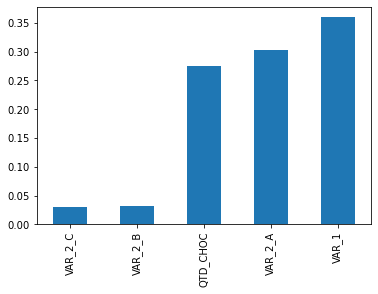

In [43]:
# importância de cada feature

feat = pd.Series(rf.feature_importances_)
feat.index = train_X.columns
feat.sort_values(ascending=True, inplace=True)
feat.plot(kind = 'bar')

O RandomForestRegressor deu uma importância muito alta para VAR_1, VAR_2 = A e QTD_CHOC, em ordem. Existe uma diferença muito alta entre essas importâncias e as de VAR_2 = B e C.

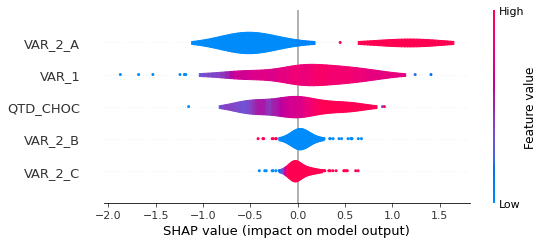

In [44]:
# shap - influência

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X, plot_type='violin')

O que mais chama atenção no SHAP é que valores positivos de VAR_2_A possuem uma influência bem alta e positiva para o modelo, causando um aumento do peso. Já os 0s possuem uma forte influência negativa.

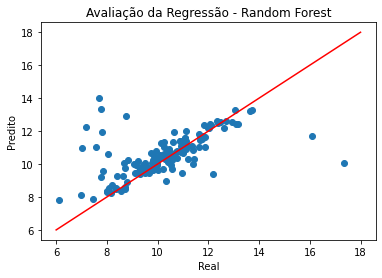

In [45]:
# Plot predição x real

fig, ax = plt.subplots(1, 1)
plt.scatter(y_test, preds_rf)
plt.plot([6,18], [6,18], color = 'r')
plt.ylabel('Predito')
plt.xlabel('Real')
plt.title('Avaliação da Regressão - Random Forest')
plt.show()

Apesar de existir alguns outliers bem discrepantes, a relação entre os valores preditos e reais é bastante linear.

In [46]:
# Criando dataset para salvar as métricas de cada modelo testado

metricas = pd.DataFrame(columns=['MSE_train', 'MAE', 'MSE', 'RMSE', 'MAPE'])

In [47]:
# salvando métricas do Random Forest

metricas.loc['Random Forest'] = [-1*fr_scores.mean(), mae, mse, rmse, mape]

### XGBoost

In [48]:
# otimização dos hiperparâmetros para XGBoost Regressor

xgb_r = xgb.XGBRegressor()

param_xgb = { 'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [5, 15, 20],
              'min_child_weight': [5, 6, 7],
              'subsample': [0.5, 0.7, 0.8],
              'colsample_bytree': [0.5, 0.7, 1],
              'colsample_bylevel':[0.2, 0.8],
              'n_estimators': [100, 350, 500, 1000],
              'random_state': [42]}

gs_xgb = GridSearchCV(estimator = xgb_r,
                      param_grid = param_xgb,
                      cv = 5,
                      n_jobs = -1,
                      verbose=2, scoring='neg_mean_squared_error')

gs_xgb.fit(train_X, y_train.values.ravel())

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bylevel': [0.2, 0.8],
                         'co

In [49]:
# melhores parâmetros entregues pelo grid search baseados na métrica MSE

gs_xgb.best_params_

{'colsample_bylevel': 0.2,
 'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 5,
 'n_estimators': 100,
 'random_state': 42,
 'subsample': 0.5}

In [50]:
# treino com melhores hiperparâmetros

xgb_r = xgb.XGBRegressor(n_estimators = 100,
                         colsample_bylevel=0.2,
                         colsample_bytree=0.7,
                         learning_rate=0.1,
                         max_depth=15,
                         min_child_weight=5,
                         subsample=0.5,
                         random_state = 42)
xgb_r.fit(train_X, y_train)
preds_xgb = xgb_r.predict(test_X)

In [51]:
# métrica treino com validação cruzada

xgb_scores = cross_val_score(xgb_r, train_X, y_train, scoring='neg_mean_squared_error')

# valor negativo por conta da maximização do mse
print('mse treino:', -1*xgb_scores.mean())

mse treino: 1.0133710650230232


In [52]:
# métricas de teste

mae = mean_absolute_error(y_test, preds_xgb)
mse = mean_squared_error(y_test, preds_xgb)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,preds_xgb)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print('MAPE:', mape)

MAE: 0.6477879086286286
MSE: 1.4456259654839672
RMSE: 1.2023418671426056
MAPE: 0.06822905266560571


<AxesSubplot:>

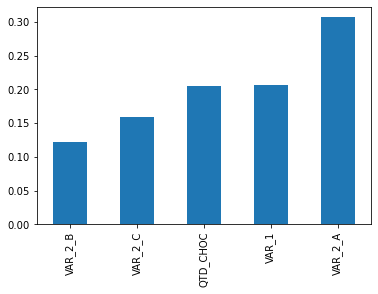

In [53]:
# importância de cada feature

feat = pd.Series(xgb_r.feature_importances_)
feat.index = train_X.columns
feat.sort_values(ascending=True, inplace=True)
feat.plot(kind = 'bar')

Para o XGBoost, a importância das variáveis foi mais distribuídas entre elas, sendo VAR_2_A a feature com mais importância.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


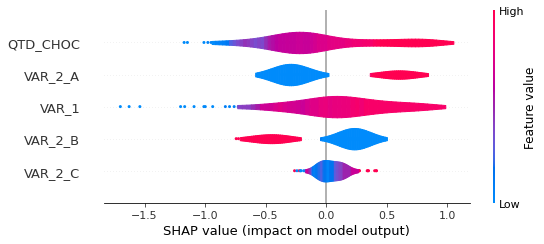

In [54]:
# shap - influência

explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X, plot_type='violin')

Valores baixos de quantidade de chocolte e VAR_1 possuem uma maior influência negativa no modelo.\
VAR_2_A e VAR_2_B possuem comportamentos contrários, enquanto o valor positivo de uma possui influência positiva, o valor positivo da outra possui uma imfluência negativa e vice-versa.

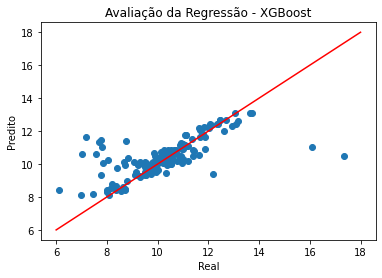

In [55]:
fig, ax = plt.subplots(1, 1)
plt.scatter(y_test, preds_xgb)
plt.plot([6,18], [6,18], color = 'r')
plt.ylabel('Predito')
plt.xlabel('Real')
plt.title('Avaliação da Regressão - XGBoost')
plt.show()

O Real x o predito pelo XGBoost também apresenta alguns outliers, mas em geral segue uma relação bastante linear.

In [56]:
# salvando métricas do XGBoost

metricas.loc['XGBoost'] = [-1*xgb_scores.mean(), mae, mse, rmse, mape]

### SVM

In [57]:
# normalizando os dados para a utilização do SVM

scaler = StandardScaler()
scaler_X_train = train_X.copy()
scaler_X_train[['QTD_CHOC', 'VAR_1']] = pd.DataFrame(scaler.fit_transform(train_X.iloc[:, [0,1]]), columns = ['QTD_CHOC', 'VAR_1'])

scaler_X_test = test_X.copy()
scaler_X_test[['QTD_CHOC', 'VAR_1']] = pd.DataFrame(scaler.transform(test_X.iloc[:, [0,1]]), columns = ['QTD_CHOC', 'VAR_1'])

In [58]:
# otimização dos hiperparâmetros

svr = SVR()

param_svr = {
    'C': [0.1, 1, 1.5, 2.5, 5, 8, 10, 50, 100, 250],
    'kernel':['rbf', 'poly', 'linear'],
    'gamma' :[0.001, 0.01, 0.1, 0.8, 1.0]}

gs_svr = GridSearchCV(svr, param_grid=param_svr, cv = 5, n_jobs=-1, verbose = 2, scoring='neg_mean_squared_error')

gs_svr.fit(scaler_X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 1.5, 2.5, 5, 8, 10, 50, 100, 250],
                         'gamma': [0.001, 0.01, 0.1, 0.8, 1.0],
                         'kernel': ['rbf', 'poly', 'linear']},
             scoring='neg_mean_squared_error', verbose=2)

In [59]:
# melhores hiperparâmetros dados pelo grid search focado na métrica MSE

gs_svr.best_params_

{'C': 8, 'gamma': 1.0, 'kernel': 'rbf'}

In [60]:
# treino com melhores hiperparâmetros do grid search

svr = SVR(C=8, gamma=1.0, kernel='rbf')
svr.fit(scaler_X_train, y_train)
preds_svr = svr.predict(scaler_X_test)

In [61]:
# métrica treino  com validação cruzada

svr_scores = cross_val_score(svr, train_X, y_train, scoring='neg_mean_squared_error')

# valor negativo por conta da maximização do mse
print('mse treino:', -1*svr_scores.mean())

mse treino: 1.7362573927279894


In [62]:
# métricas de teste

mae = mean_absolute_error(y_test, preds_svr)
mse = mean_squared_error(y_test, preds_svr)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,preds_svr)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print('MAPE:', mape)

MAE: 0.7617305542167682
MSE: 2.3716653385719146
RMSE: 1.5400212136759397
MAPE: 0.08144778499747503


Using 350 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 350/350 [02:35<00:00,  2.25it/s]


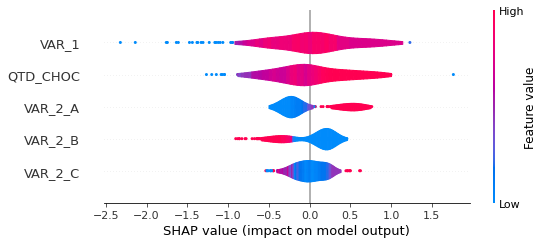

In [63]:
# shap - influência

explainer = shap.KernelExplainer(svr.predict, pd.DataFrame(scaler_X_train, columns = train_X.columns))
shap_values = explainer.shap_values(pd.DataFrame(scaler_X_train, columns = train_X.columns))
shap.summary_plot(shap_values, pd.DataFrame(scaler_X_train, columns = train_X.columns), plot_type='violin')

De mais interessante a ser observado pelo gráfico das influências, temos as variáveis VAR_2_A e VAR_2_B, que possuem comportamentos opostos e a mesma observação realizada no modelo XGBoost também pode ser realizada aqui.

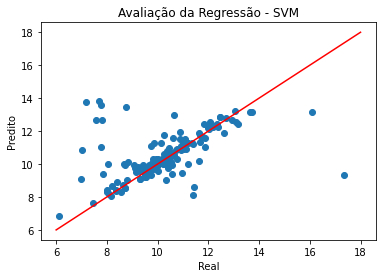

In [66]:
fig, ax = plt.subplots(1, 1)
plt.scatter(y_test, preds_svr)
plt.plot([6,18], [6,18], color = 'r')
plt.ylabel('Predito')
plt.xlabel('Real')
plt.title('Avaliação da Regressão - SVM')
plt.show()

O gráfico dos valores reais x predições do SVM apresenta banstantes outliers, o que explica as métricas não tão satisfatórias.

In [67]:
metricas.loc['SVM'] = [-1*svr_scores.mean(), mae, mse, rmse, mape]

### Conclusões

In [68]:
# comparando performance dos modelos
metricas

,MSE_train,MAE,MSE,RMSE,MAPE
Random Forest,0.949660,0.717277,1.941541,1.393392,0.076308
XGBoost,1.013371,0.647788,1.445626,1.202342,0.068229
SVM,1.736257,0.761731,2.371665,1.540021,0.081448


Pode-se observar que o modelo que em geral apresentou as melhores métricas de teste foi o XGBoost, além de ter apresentado uma diferença menor no MSE de treino e teste em relação aos outros modelos testados.\
Todos os modelos deram uma importância e influência bem característica para VAR_2 = A, sendo essa classificação bastante influente para um peso maior.\
Em geral, VAR_2 = B tem influência na diminuição do peso do bombom.\
Muitas das observações que podem ser feitas a partir da importância e influência das variáveis em cada modelo já foram realizadas nas etapas descritivas e diagnósticas deste projeto.


#### Predição com modelo escolhido

In [69]:
df_pred = pd.read_excel('../analise-preditiva.xlsx')

In [70]:
df_pred.shape

(50, 4)

In [71]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   QTD_CHOC     50 non-null     float64
 1   VAR_1        50 non-null     float64
 2   VAR_2        50 non-null     object 
 3   PESO_BOMBOM  0 non-null      float64
dtypes: float64(3), object(1)
memory usage: 1.7+ KB


In [72]:
# encoder fitado no treino do modelo
onehot_pred = pd.DataFrame(encoder.transform(df_pred[['VAR_2']]).toarray())
onehot_pred.columns = encoder.get_feature_names(['VAR_2'])
final_pred = df_pred.drop(columns = 'VAR_2').join(onehot_pred)

In [73]:
# predict

preds = xgb_r.predict(final_pred.drop(columns = 'PESO_BOMBOM'))

In [74]:
df_pred['PESO_BOMBOM'] = preds

In [75]:
df_pred.PESO_BOMBOM.describe()

count    50.000000
mean     10.250996
std       1.118843
min       7.795401
25%       9.461938
50%      10.115543
75%      10.688929
max      12.758789
Name: PESO_BOMBOM, dtype: float64

In [76]:
# salvando predições

df_pred.to_excel('..\predicoes.xlsx', index=False)

## Análise Prescritiva

A otimização da quantidade de chocolate é feita a partir da minimização do custo para um peso, mas o peso depende da quantidade de chocolate e dos valores de VAR_1 e VAR_2.

- Minimizar cost_value()
- Determinar limites dentro do histórico de bombons úteis

In [77]:
# utilizando OLS para obter os coeficientes da regressão

X = train_X.copy()
y = y_train.reset_index(drop=True).copy()
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()

# coeficientes de OLS
result.params

const       4.124360
QTD_CHOC    0.011936
VAR_1       0.695271
VAR_2_A     2.254125
VAR_2_B     0.489783
VAR_2_C     1.380452
dtype: float64

Dessa forma a equação da regressão é:
$$ (0.011936)*CHOC + (0.695271)*VAR1 + (2.254125)*VAR2_A + (0.489783)*VAR2_B + (1.380452)*VAR2_C + 4.124360 = PESO $$

In [78]:
# obtendo o menor valor possível da função custo, assim consigo o menor peso possível (peso que minimiza a função custo)

fmin(cost_value, 9)

Optimization terminated successfully.
         Current function value: 34.690398
         Iterations: 15
         Function evaluations: 30


array([9.949823])

Custo mínimo: 34.690398\
Peso para custo mínimo: 9.949823

In [79]:
# criando função da regressão

def choc(row):
    """Cálculo da quantidade de chocolate necessária para se obter um peso do bombom de 9.949823.

    Args:
        row (pandas series): linha do dataset

    Returns:
        float: quantidade de chocolate necessária para minimizar o custo dada as variáveis
    """
    var1 = row[1]
    var2_a = row[2]
    var2_b = row[3]
    var2_c = row[4]
    qnt_choc = (9.949823 - ((0.695271)*var1 + (2.254125)*var2_a + (0.489783)*var2_b + (1.380452)*var2_c + 4.124360))/(0.011936)
    return qnt_choc


In [80]:
# dataset para análise prescritiva

df_presc = pd.read_excel('../analise-prescritiva.xlsx')

In [81]:
# verificando informações do dataset da prescrição

df_presc.shape

(50, 3)

In [82]:
# verificando se os tipos das variáveis e nomes de colunas são os mesmos dos das variáveis do treino e existência de nulos
df_presc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   QTD_CHOC  0 non-null      float64
 1   VAR_1     50 non-null     float64
 2   VAR_2     50 non-null     object 
dtypes: float64(2), object(1)
memory usage: 1.3+ KB


In [83]:
# encoder fitado no treino do modelo
onehot_presc = pd.DataFrame(encoder.transform(df_presc[['VAR_2']]).toarray())
onehot_presc.columns = encoder.get_feature_names(['VAR_2'])
final_presc = df_presc.drop(columns = 'VAR_2').join(onehot_presc)

In [84]:
# cálculo da quantidade de chocolate necessária

df_presc['QTD_CHOC'] = final_presc.apply(lambda x: choc(x), axis=1)

In [85]:
# salvando prescrições
df_presc.to_excel('..\prescricoes.xlsx', index=False)

### Análise peso do bombom com quantidade de chocolate prescrita

In [86]:
final_presc['QTD_CHOC'] = final_presc.apply(lambda x: choc(x), axis=1)
final_presc = sm.add_constant(final_presc)

In [87]:
preds = result.predict(final_presc)

In [88]:
# cálculo do peso do bombom
final_presc['PESO_BOMBOM'] = preds

In [89]:
# cálculo do custo de cada bombom
final_presc['CUSTO'] = cost_value(final_presc['PESO_BOMBOM'])

In [90]:
final_presc[['PESO_BOMBOM', 'CUSTO']].describe()

,PESO_BOMBOM,CUSTO
count,50.000000,5.000000e+01
mean,9.949842,3.469040e+01
std,0.000005,1.653526e-08
min,9.949834,3.469040e+01
25%,9.949839,3.469040e+01
50%,9.949841,3.469040e+01
75%,9.949845,3.469040e+01
max,9.949854,3.469040e+01


Seria necessária uma análise mais aprofundada, mas, por enquanto, foi gerado um MVP para a prescrição.

O passo a passo do desenvolvimento do modelo de otimização foi realizado da seguinte forma: 
- Obtidos os coeficientes beta da equação característica da regressão linear (OLS) dos dados de treino (arquivo registros-prod.xlsx).
- A partir da função custo, foi encontrado o menor peso aceitável que gerasse o menor custo possível (mínimo global).
- Esse valor do peso substituiu a incógnita dentro da equação característica da regressão para que fosse possível obter a quantidade de chocolate necessária - levando em consideração VAR_1 e VAR_2 - para minimizar o custo.
- Foi calculado o custo a partir do peso predito para as variáveis de cada bombom (modelo OLS).
- Dessa forma, dentro dos registros da prescrição, não houve nenhum caso de bombom fora dos padrões - isso vem do fato da equação característica limitar o peso do bombom.

Uma análise interessante de se fazer posteriormente seria substituir a quantidade de chocolate dos dados de treino pela quantidade recomendada pelo modelo de prescrição obtido e comparar o custo real e o custo da prescrição, utilizando o peso real e o peso predito. Assim o ganho do processo poderia ser avaliado.